In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, SpatialDropout1D, GRU, Bidirectional
from keras.utils import pad_sequences

In [2]:
strategy  = tf.distribute.get_strategy()

In [3]:
train = pd.read_csv('./data/jigsaw-toxic-comment-train.csv')
test = pd.read_csv('./data/test.csv')
validation = pd.read_csv('./data/validation.csv')

In [4]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [5]:
train.drop(['severe_toxic','obscene', 'threat','insult', 'identity_hate'], axis=1, inplace = True)

In [6]:
train = train.loc[:12000, :]

In [7]:
train.shape

(12001, 3)

In [8]:
train.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


check một comment có tối đa bao nhiêu chữ

In [9]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

hàm đánh giá mô hình

In [10]:
def roc_auc(predictions, target):
    """
        Method to return  the AUC score when giving the predictions
    """
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

chia tập dữ liệu thành 2 phần, 8 phần train, 2 phần test

In [11]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, stratify= train.toxic.values
                                                  , random_state=42, test_size=0.2, shuffle=True)

In [12]:
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))

In [13]:
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

In [14]:
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

In [15]:
word_index = token.word_index

In [16]:
with strategy.scope():
    # a simple rnn 
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 300, input_length = max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy",optimizer = "adam", metrics=['accuracy'])
model.summary()
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         13049100  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 13,089,301
Trainable params: 13,089,301
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(xtrain_pad, ytrain, epochs=1, batch_size=64*strategy.num_replicas_in_sync)

150/150 [==============================] - 112s 727ms/step - loss: 0.3305 - accuracy: 0.8878


In [18]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores, yvalid)))

76/76 [==============================] - 9s 116ms/step
Auc: 0.73%


Load GloVe vectors

In [ ]:
from tqdm import tqdm

In [20]:
embedding_index = {}
f = open('./embedding/glove.840B.300d.txt', 'r', encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embedding_index[word] = coefs
f.close()

print(f"Found {len(embedding_index)} word vectors")

2196018it [02:35, 14086.89it/s]


Found 2196017 word vectors


Create an embedding matrix for the words we have in dataset

In [27]:
len(word_index)

43496

In [28]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 43496/43496 [00:07<00:00, 5695.11it/s]


Building a simple LSTM

In [51]:
del model

In [52]:
with strategy.scope():
    # a simple rnn 
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights = [embedding_matrix],
                        input_length = max_len,
                        trainable = False))
    #add dropout as reguralization method to prevent overfitting
    model.add(LSTM(100, dropout=0.3))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy",optimizer = "adam", metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1500, 300)         13049100  
                                                                 
 lstm_9 (LSTM)               (None, 100)               160400    
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 13,209,601
Trainable params: 160,501
Non-trainable params: 13,049,100
_________________________________________________________________


In [53]:
history = model.fit(xtrain_pad, ytrain, validation_split=0.1, epochs=5, batch_size=32*strategy.num_replicas_in_sync)

Epoch 1/5


270/270 [==============================] - 32s 114ms/step - loss: 0.1931 - accuracy: 0.9309 - val_loss: 0.1410 - val_accuracy: 0.9531
Epoch 2/5
270/270 [==============================] - 30s 112ms/step - loss: 0.1404 - accuracy: 0.9519 - val_loss: 0.1282 - val_accuracy: 0.9542
Epoch 3/5
270/270 [==============================] - 30s 110ms/step - loss: 0.1289 - accuracy: 0.9556 - val_loss: 0.1228 - val_accuracy: 0.9573
Epoch 4/5
270/270 [==============================] - 29s 109ms/step - loss: 0.1058 - accuracy: 0.9630 - val_loss: 0.1151 - val_accuracy: 0.9563
Epoch 5/5
270/270 [==============================] - 30s 111ms/step - loss: 0.0982 - accuracy: 0.9640 - val_loss: 0.1173 - val_accuracy: 0.9573


In [50]:
import matplotlib.pyplot as plt 

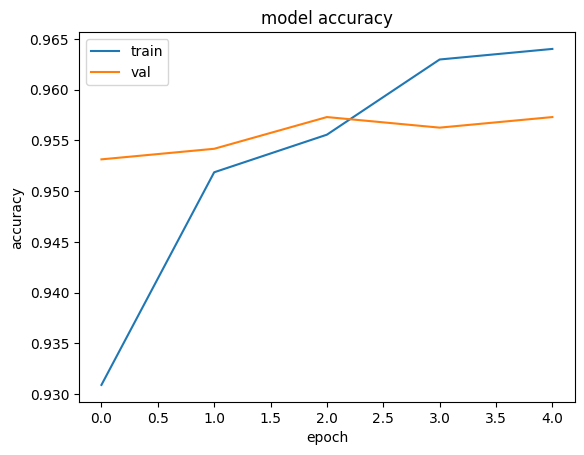

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

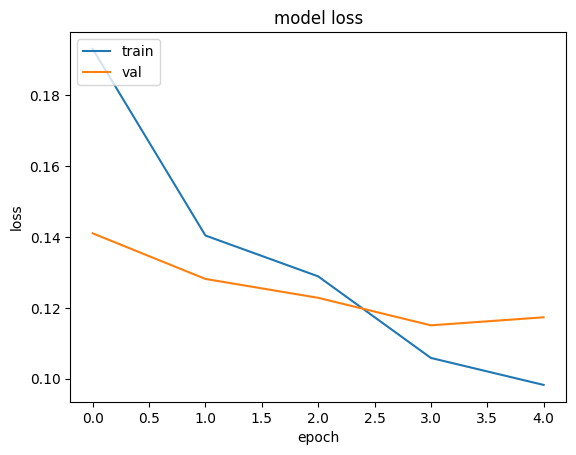

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [56]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores, yvalid)))

76/76 [==============================] - 4s 50ms/step
Auc: 0.97%


In [76]:
sample_pred = model.predict(sample_pad)

2/2 [==============================] - 0s 69ms/step


Model Using GRU Layer

In [82]:
with strategy.scope():
    # a simple rnn 
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights = [embedding_matrix],
                        input_length = max_len,
                        trainable = False))
    model.add(SpatialDropout1D(0.3))
    model.add(GRU(100))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy",optimizer = "adam", metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 1500, 300)         13049100  
                                                                 
 spatial_dropout1d (SpatialD  (None, 1500, 300)        0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 100)               120600    
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 13,169,801
Trainable params: 120,701
Non-trainable params: 13,049,100
_________________________________________________________________


In [83]:
history = model.fit(xtrain_pad, ytrain, validation_split=0.1, epochs=5, batch_size=32*strategy.num_replicas_in_sync)

Epoch 1/5
270/270 [==============================] - 31s 111ms/step - loss: 0.2090 - accuracy: 0.9326 - val_loss: 0.1352 - val_accuracy: 0.9500
Epoch 2/5
270/270 [==============================] - 27s 101ms/step - loss: 0.1318 - accuracy: 0.9527 - val_loss: 0.1092 - val_accuracy: 0.9521
Epoch 3/5
270/270 [==============================] - 27s 99ms/step - loss: 0.1093 - accuracy: 0.9603 - val_loss: 0.1016 - val_accuracy: 0.9625
Epoch 4/5
270/270 [==============================] - 27s 100ms/step - loss: 0.0962 - accuracy: 0.9632 - val_loss: 0.1041 - val_accuracy: 0.9594
Epoch 5/5
270/270 [==============================] - 27s 101ms/step - loss: 0.0877 - accuracy: 0.9688 - val_loss: 0.1051 - val_accuracy: 0.9615


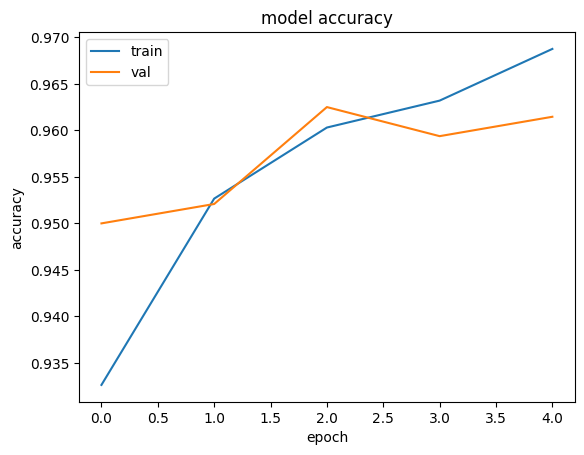

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

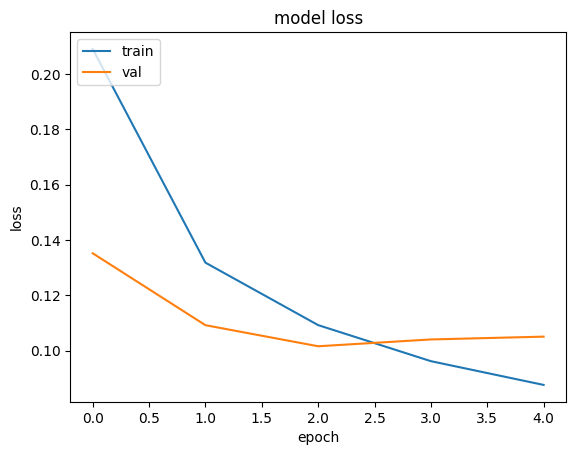

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [86]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores, yvalid)))

76/76 [==============================] - 4s 48ms/step
Auc: 0.98%


Bidirectional

In [16]:
with strategy.scope():
    # a simple rnn 
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights = [embedding_matrix],
                        input_length = max_len,
                        trainable = False))
    #add dropout as reguralization method to prevent overfitting
    model.add(Bidirectional(LSTM(100, dropout=0.3)))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy",optimizer = "adam", metrics=['accuracy'])
model.summary()

NameError: name 'embedding_matrix' is not defined

In [89]:
history = model.fit(xtrain_pad, ytrain, validation_split=0.1, epochs=5, batch_size=32*strategy.num_replicas_in_sync)

Epoch 1/5


InternalError: Graph execution error:

Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 300, 300, 1, 1500, 32, 300] 
	 [[{{node CudnnRNN}}]]
	 [[sequential_13/bidirectional/backward_lstm_10/PartitionedCall]] [Op:__inference_train_function_64941]